<h1> Validate libNEST for S1S2 with LUX data, at 180 V/cm</h1>

In [1]:
from __future__ import division
import sys
loc_dir=!pwd
sys.path.insert(2,loc_dir[0]+'/../') #add path to import libNEST... step back one level
import libNEST
import pandas as pd
import scipy.interpolate as ip
import scipy.io as sio
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 18})

#Need to add this to make Skin Response maps load in
import os
os.environ['NESTPATH']=loc_dir[0]+'/../'
#os.environ['NESTDATA']=loc_dir[0]+'/../../LCEAndEFieldMaps/'
os.environ['NESTDATA']='/cvmfs/lz.opensciencegrid.org/fastNEST/LCEAndFieldMaps/'

Populating the interactive namespace from numpy and matplotlib


<h1> Load in the Run03 LUX yields, from calibration data </h1>

In [2]:
CH3T_yield=loadtxt('data_yields/LUX_Dec2013_CH3T_Yields.txt',skiprows=1).T
DD_ly=loadtxt('data_yields/LUX_DD_LY.txt',skiprows=2).T
DD_qy=loadtxt('data_yields/LUX_DD_QY.txt',skiprows=2).T
DD_S1S2=loadtxt('data_yields/LUX_DD_S1S2.txt',skiprows=2).T
LUX2013ER_yield=loadtxt('data_yields/LUX_ER_lines.txt',skiprows=1).T
CH3T_2013_S2S1band=loadtxt('data_yields/LUX_Dec2013_CH3T_S2S1.txt',skiprows=1).T
CH3T_2013_S2S1band_Aug=loadtxt('data_yields/LUX_Aug2013_CH3T_S1S2.txt',skiprows=1).T

#Load in rootNEST LUX tritium sim
CH3T_2013_rootNEST=loadtxt('data_yields/LUX_CH3T.txt',skiprows=1).T
S1c_rNest=CH3T_2013_rootNEST[4]
S2c_rNest=CH3T_2013_rootNEST[6]

<h1> Load in results from rootNEST.cc (latest LZ-git version)</h1>

In [3]:
rootNEST_ER_en=[1,2,3,4,5,6,7,8,10,15,30,50,90,100,200,300,500,600,900]
rootNEST_ER_LY=[]
rootNEST_ER_QY=[]

for en in rootNEST_ER_en:
    temp=loadtxt('data_yields/rootNEST_'+str(en)+'.txt',skiprows=1).T
    rootNEST_ER_LY.append(mean(temp[1])/mean(temp[0]))
    rootNEST_ER_QY.append(mean(temp[2])/mean(temp[0]))
    
#now for NR
rootNEST_NR_en=[1,2,5,10,30]
rootNEST_NR_LY=[]
rootNEST_NR_QY=[]

for en in rootNEST_NR_en:
    temp=loadtxt('data_yields/rootNEST_nr_'+str(en)+'.txt',skiprows=1).T
    rootNEST_NR_LY.append(mean(temp[1])/mean(temp[0]))
    rootNEST_NR_QY.append(mean(temp[2])/mean(temp[0]))

<h1> Get S1 S2 for tritium beta spectrum with LUX detector settings </h1>

<h3> Define a tritium beta spectrum, http://www.hindawi.com/journals/ahep/2013/293986/ </h3>

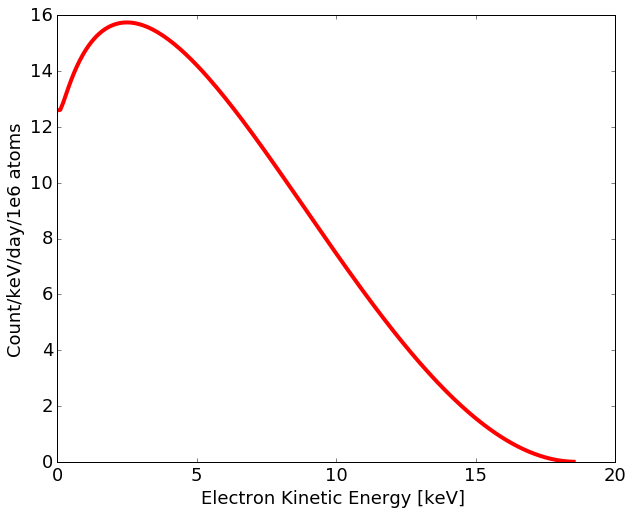

In [4]:
c=1;    # speed of light
C=1e-6; #constant infront of Fermi funciton. Arbitrary. Read Katrin paper if you care about super-allowed and allowed transitions... and nuclear matrix elements that don't matter
me = 511/c**2; # rest mass of our good friend the electron, in keV
Q=18.6 # endpoint of the tritium Beta decay keV. Maximum kinetic energy the electron.
mv=0   # neutrino mass=0. There may exist a 17 keV neutrino, maybe 7 keV!! Will we ever know??? Is it The Dark Matter?? Mystery...
step_T=0.1 #step energy by 0.1 keV
T=arange(0.01, 18.6,step_T) #sweep from 0.01 to the Q value in increments of step_T.
Z=1+1; #Tritium, after the beta decay Z'=1+1;
halflife = 12.32; # half life of the tritium beta decay in years
tau = 365*halflife/0.69; # Decay constant converted to days
n = 1e6; # Assume 1e6 atoms are decaying.
G=(T+me*c**2)/(me*c**2); #Gamma, Total energy(E+M^2) over M^2
B=sqrt((G**2-1)/G**2); # v/c of electron. Ratio of velocity to speed of light in vacuum.
x=(2*pi*Z/137)/B; # note: fine structure constant = 137. 
F_Kat=x*(1/(1-exp(-x))); # Katrin paper... http://www.hindawi.com/journals/ahep/2013/293986/ (really the same thing)
KE=T; #(G-1).*me*c^2; % The kinetic energy, is equal to T
E=KE+me*c**2; # the total energy. KE + rest mass
P=sqrt(E**2-me**2*c**4)/c; # momentum of the electron
N=C*F_Kat*(KE+me)*sqrt((KE+me)**2-me**2)*(Q-KE)**2 # eqution 18 of Katrin paper. Set nutrino mass to zero... http://www.hindawi.com/journals/ahep/2013/293986/ (really the same thing)
s = sum(N[~isnan(N)])*step_T # Total Counts
N = N * (1/s * n/tau) # Decays/keV/day/1e6 atoms

#plot to se beta spectrum for tritium 
figure(0)
plt.plot(T,N,'r',linewidth=4)
plt.xlabel('Electron Kinetic Energy [keV] ',fontsize=18)
plt.ylabel('Count/keV/day/1e6 atoms',fontsize=18)


<h3> Run beta spectrum through NEST and get S1 S2 responce to compare with LUX data </h3>

<h1> Compare to LUX Dec 2013 CH3T Data </h1>

In [5]:
NEST=libNEST.NEST(1,100,-1,2.888,-1) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density, dT
myDet=libNEST.Detector()
myDet.LUXSettings()
    
#Mod to Dec2013 data vs. 2013 WS.
myDet.g1_gas=myDet.g1_gas*(23.77/24.66)
myDet.g1 = 0.114
myDet.ee= 0.504
#myDet.spEff_direct=1
NEST.SetDetectorParameters(myDet)

#####
trial_m=200; # about 150k with trial_m = 100
trials=sum(ceil(N*trial_m)); #tritium dN/dE is fractional so multiply amplitute. 
subtrials=np.ones((N.size,1));

S1c=np.ones((trials,1)); #  Tritium gamma spectrum
S2c=np.ones((trials,1));     #  Tritium electron spectrum.

kk=0; # kk will equal the total number of simulated tritium events

for jj in range(0, T.size): #% sweep through each energy bin
    print(jj),
    subtrials[jj]=ceil(N[jj]*trial_m)
    energy=T[jj]
    NEST.SetEnergy(energy)
    for ii in range(0, subtrials[jj]-1):
        NEST.DetectorResponse() #throw the dice
        S1c[kk]=NEST.GetS1c()
        S2c[kk]=NEST.GetS2c()
        kk=kk+1

#calculate ER band of the SIM
cut=(S1c>0) & (S2c>0)
S1c=S1c[cut]
S2c=S2c[cut]
s2s1_sim=log10(S2c/S1c)

S2S1_er_mean=[]
S2S1_er_sig=[]

S1_er_cen=np.arange(1.5,80.5,1)
for s1_bins in S1_er_cen:
    S2S1_er_mean.append(mean(s2s1_sim[(S1c>(s1_bins-0.5))&(S1c<(s1_bins+0.5))]))
    S2S1_er_sig.append(std(s2s1_sim[(S1c>(s1_bins-0.5))&(S1c<(s1_bins+0.5))]))
S2S1_er_mean=np.array(S2S1_er_mean)
S2S1_er_sig=np.array(S2S1_er_sig)

##### Do the same for rootNEST results
#calculate ER band of the SIM
cut=(S1c_rNest>0) & (S2c_rNest>0)
S1c_rNest=S1c_rNest[cut]
S2c_rNest=S2c_rNest[cut]
s2s1_rNest=log10(S2c_rNest/S1c_rNest)

S2S1_er_mean_rN=[]
S2S1_er_sig_rN=[]

S1_er_cen_rN=np.arange(1.5,80.5,1)
for s1_bins in S1_er_cen_rN:
    S2S1_er_mean_rN.append(mean(s2s1_rNest[(S1c_rNest>(s1_bins-0.5))&(S1c_rNest<(s1_bins+0.5))]))
    S2S1_er_sig_rN.append(std(s2s1_rNest[(S1c_rNest>(s1_bins-0.5))&(S1c_rNest<(s1_bins+0.5))]))
S2S1_er_mean_rN=np.array(S2S1_er_mean_rN)
S2S1_er_sig_rN=np.array(S2S1_er_sig_rN)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185


In [6]:
#save mat file
S=dict([('S1c',S1c),('S2c',S2c)])
#save mat
sio.savemat('NEST_Yields/FN_CH3T_S1S2',S)

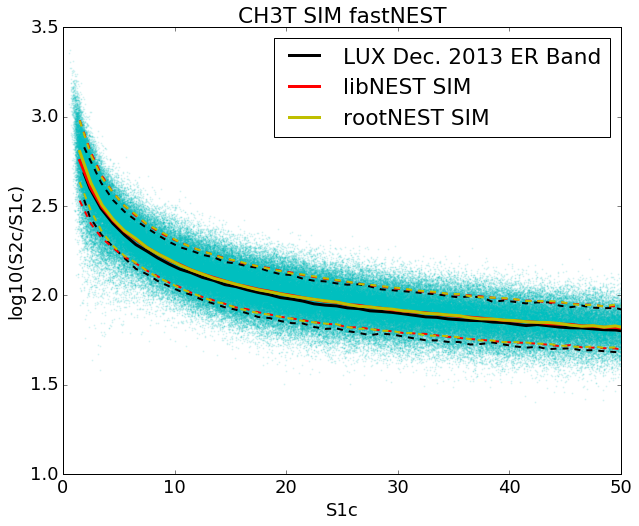

In [7]:
plt.scatter(S1c,s2s1_sim,alpha=0.1,color='c',s=1)
#plt.scatter(S1c_rNest,s2s1_rNest,alpha=0.1,color='y',s=1)
xlabel('S1c')
ylabel('log10(S2c/S1c)')
ylim([1,3.5])
xlim([0,50])
#plot LUX data
ax1=plt.plot(CH3T_2013_S2S1band[0],CH3T_2013_S2S1band[2],'-k',linewidth=3)
#plot SIM fit
ax2=plt.plot(S1_er_cen,S2S1_er_mean,'-r',linewidth=3)
#plot rootNEST SIM fit
ax3=plt.plot(S1_er_cen_rN,S2S1_er_mean_rN,'-y',linewidth=3)

#plot bands
plt.plot(CH3T_2013_S2S1band[0],CH3T_2013_S2S1band[4],'--k',linewidth=2)
plt.plot(CH3T_2013_S2S1band[0],CH3T_2013_S2S1band[5],'--k',linewidth=2)

plt.plot(S1_er_cen,S2S1_er_mean-1.28*S2S1_er_sig,'--r',linewidth=2)
plt.plot(S1_er_cen,S2S1_er_mean+1.28*S2S1_er_sig,'--r',linewidth=2)

plt.plot(S1_er_cen_rN,S2S1_er_mean_rN-1.28*S2S1_er_sig_rN,'--y',linewidth=2)
plt.plot(S1_er_cen_rN,S2S1_er_mean_rN+1.28*S2S1_er_sig_rN,'--y',linewidth=2)


plt.title('CH3T SIM fastNEST')
legend(("LUX Dec. 2013 ER Band","libNEST SIM","rootNEST SIM"))
plt.savefig('val_figs/CH3T_LUX_val.png')

<h1> Compare to LUX Aug 2013 CH3T Data </h1>

In [8]:
NEST=libNEST.NEST(1,100,180,2.888,-1) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LUXSettings()
NEST.SetDetectorParameters(myDet)

#####
trial_m=100; # about 150k with trial_m = 100
trials=sum(ceil(N*trial_m)); #tritium dN/dE is fractional so multiply amplitute. 
subtrials=np.ones((N.size,1));

S1c=np.ones((trials,1)); #  Tritium gamma spectrum
S2c=np.ones((trials,1));     #  Tritium electron spectrum.

kk=0; # kk will equal the total number of simulated tritium events

for jj in range(0, T.size): #% sweep through each energy bin
    print(jj),
    subtrials[jj]=ceil(N[jj]*trial_m)
    energy=T[jj]
    NEST.SetEnergy(energy)
    for ii in range(0, subtrials[jj]-1):
        NEST.DetectorResponse() #throw the dice
        S1c[kk]=NEST.GetS1c()
        S2c[kk]=NEST.GetS2c()
        kk=kk+1

#calculate ER band of the SIM
cut=(S1c>0) & (S2c>0)
S1c=S1c[cut]
S2c=S2c[cut]
s2s1_sim=log10(S2c/S1c)

S2S1_er_mean=[]
S2S1_er_sig=[]

S1_er_cen=np.arange(1.5,80.5,1)
for s1_bins in S1_er_cen:
    S2S1_er_mean.append(mean(s2s1_sim[(S1c>(s1_bins-0.5))&(S1c<(s1_bins+0.5))]))
    S2S1_er_sig.append(std(s2s1_sim[(S1c>(s1_bins-0.5))&(S1c<(s1_bins+0.5))]))
S2S1_er_mean=np.array(S2S1_er_mean)
S2S1_er_sig=np.array(S2S1_er_sig)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185


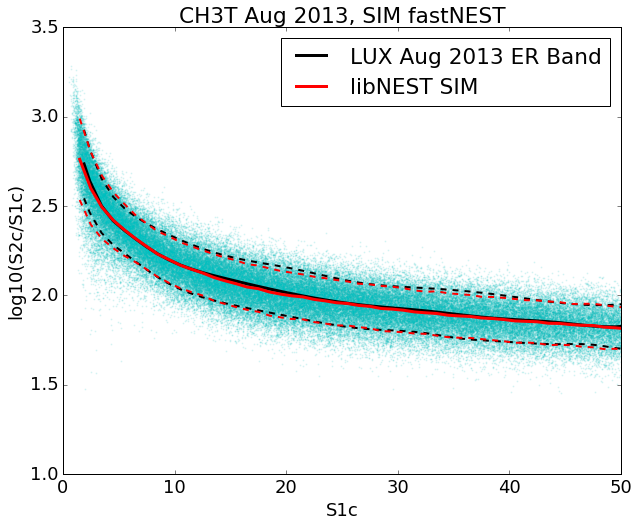

In [9]:
#plot LUX data
plt.scatter(S1c,s2s1_sim,alpha=0.1,color='c',s=1)
#plt.scatter(S1c_rNest,s2s1_rNest,alpha=0.1,color='y',s=1)
xlabel('S1c')
ylabel('log10(S2c/S1c)')
ylim([1,3.5])
xlim([0,50])
#plot LUX data
sAugBand = ip.UnivariateSpline(CH3T_2013_S2S1band_Aug[0], CH3T_2013_S2S1band_Aug[2],s=.01)
ax1=plt.plot(CH3T_2013_S2S1band_Aug[0],sAugBand(CH3T_2013_S2S1band_Aug[0]),'-k',linewidth=3)
#plot SIM fit
ax2=plt.plot(S1_er_cen,S2S1_er_mean,'-r',linewidth=3)
#plot rootNEST SIM fit
#ax3=plt.plot(S1_er_cen_rN,S2S1_er_mean_rN,'-y',linewidth=3)

#plot bands
sAugBand_l = ip.UnivariateSpline(CH3T_2013_S2S1band_Aug[0], CH3T_2013_S2S1band_Aug[4],s=.02)
sAugBand_u = ip.UnivariateSpline(CH3T_2013_S2S1band_Aug[0], CH3T_2013_S2S1band_Aug[5],s=.02)
plt.plot(CH3T_2013_S2S1band_Aug[0],sAugBand_l(CH3T_2013_S2S1band_Aug[0]),'--k',linewidth=2)
plt.plot(CH3T_2013_S2S1band_Aug[0],sAugBand_u(CH3T_2013_S2S1band_Aug[0]),'--k',linewidth=2)

plt.plot(S1_er_cen,S2S1_er_mean-1.28*S2S1_er_sig,'--r',linewidth=2)
plt.plot(S1_er_cen,S2S1_er_mean+1.28*S2S1_er_sig,'--r',linewidth=2)

#plt.plot(S1_er_cen_rN,S2S1_er_mean_rN-1.28*S2S1_er_sig_rN,'--y',linewidth=2)
#plt.plot(S1_er_cen_rN,S2S1_er_mean_rN+1.28*S2S1_er_sig_rN,'--y',linewidth=2)


plt.title('CH3T Aug 2013, SIM fastNEST')
legend(("LUX Aug 2013 ER Band","libNEST SIM"))
plt.savefig('val_figs/CH3T_LUX_Aug2013_val.png')

<h1> Calculate S2 S1 of DD data in LUX </h1>

In [10]:
NEST=libNEST.NEST(0,10,180,2.888,-1) # 0 is NR, 1 is ER ... Energy, EField(V/cm), density
myDet=libNEST.Detector()
myDet.LUXSettings()
myDet.g1=0.114
myDet.ee=0.465
myDet.g1_gas =myDet.g1_gas*(23.77/24.66)
myDet.dt_min=80
myDet.dtCntr=105
myDet.dt_max=130
NEST.SetDetectorParameters(myDet)

S1c_nr=[]
S2c_nr=[]
Energy = linspace(1,50,100)

for En in Energy:
    NEST.SetEnergy(En)
    for ii in arange(0,1000,1):
        NEST.DetectorResponse()
        S1c_nr.append(NEST.GetS1c())
        S2c_nr.append(NEST.GetS2c())
S1c_nr=np.array(S1c_nr)
S2c_nr=np.array(S2c_nr)

#calculate NR band of the SIM
cut=(S1c_nr>0) & (S2c_nr>0)
S1c_nr=S1c_nr[cut]
S2c_nr=S2c_nr[cut]
s2s1_sim_nr=log10(S2c_nr/S1c_nr)

S2S1_nr_mean=[]
S2S1_nr_sig=[]

S1_nr_cen=np.arange(1.5,80.5,1)
for s1_bins in S1_nr_cen:
    S2S1_nr_mean.append(mean(s2s1_sim_nr[(S1c_nr>(s1_bins-0.5))&(S1c_nr<(s1_bins+0.5))]))
    S2S1_nr_sig.append(std(s2s1_sim_nr[(S1c_nr>(s1_bins-0.5))&(S1c_nr<(s1_bins+0.5))]))
S2S1_nr_mean=np.array(S2S1_nr_mean)
S2S1_nr_sig=np.array(S2S1_nr_sig)

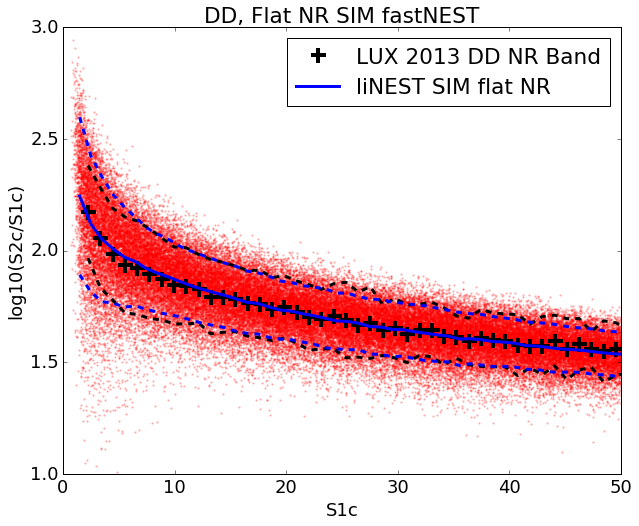

In [11]:
plt.scatter(S1c_nr,log10(S2c_nr/S1c_nr),alpha=0.2,color='red',s=2)
#plt.scatter(S1c_er,log10(S2c_er/S1c_er),alpha=0.3,color='blue',s=2)
xlabel('S1c')
ylabel('log10(S2c/S1c)')
ylim([1,3])
xlim([0,50])

#plot LUX DD NR band:
p2=plt.plot(DD_S1S2[0],DD_S1S2[1],'+k',linewidth=3,markersize=15, markeredgewidth=4, label="LUX 2013 DD NR Band")
plt.plot(DD_S1S2[0],DD_S1S2[1]-1.28*DD_S1S2[4],'--k',linewidth=3)
plt.plot(DD_S1S2[0],DD_S1S2[1]+1.28*DD_S1S2[4],'--k',linewidth=3)

p1=plt.plot(S1_nr_cen,S2S1_nr_mean,'-b',linewidth=3, label="liNEST SIM flat NR")
plt.plot(S1_nr_cen,S2S1_nr_mean-1.28*S2S1_nr_sig,'--b',linewidth=3)
plt.plot(S1_nr_cen,S2S1_nr_mean+1.28*S2S1_nr_sig,'--b',linewidth=3)


plt.title('DD, Flat NR SIM fastNEST')
plt.legend(numpoints=1) #("LUX DD 2013 NR Band","libNEST flat SIM")
plt.savefig('val_figs/LUX_NR_DD-v-flat_val.png')